# Image Analysis with Python - <font color='teal'>Tutorial Pipeline Section 2</font>

*originally created in 2016*<br>
*updated and converted to a Jupyter notebook in 2017*<br>
*updated and converted to python 3 in 2018*<br>
*by Jonas Hartmann (Gilmour group, EMBL Heidelberg)*<br>
*updated in 2022 by Cheng-Yu Huang*<br>

##  Table of Contents

1. [About this Tutorial](#about)
2. [Initialization](#initialize)
11. [Postprocessing: Removing Cells at the Image Border](#postpro)
12. [Identifying Cell Edges](#edges)
13. [Extracting Quantitative Measurements](#measure)
14. [Simple Analysis & Visualization](#analysis)
15. [Writing Output to Files](#write)
16. [BONUS - Batch Processing](#batch)

##  About this Tutorial <a id=about></a>

*This tutorial covers the part 2 of the image analysis tutorial*


#### Instructions

- In the section 1 of the Codelab, you performed adaptive thresholding and connected-component analysis of our raw image.

- Here we are going to continue from where we left behind, starting with the segmentation result, we will first clean all the cell patches near the border of the image, and detect the edge of each cells. Then we will perform the statistical analysis to the results.

## Initialization <a id=initialize></a>

In this section we will import all the necessary modules and packages. Then we will load the raw image data and our segmentation results, for further processing

In [1]:
# (i) Importing all the necessary modules and packages

# The numerical arrays manipulation module numpy as np
# The plotting module matplotlib.pyplot as plt
# The image processing module scipy.ndimage as ndi
### YOUR CODE HERE!
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

In [2]:
# (ii) Set matplotlib backend

### YOUR CODE HERE!
%matplotlib inline 

In [3]:
# (iii) Specify the directory path and file name

# Create a string variable with the relative (or absolute) path to your raw image
# and segmentation results. 
### YOUR CODE HERE!
img_filepath = r'example_data\example_cells_1.tif'
seg_filepath = r'example_cells_1_seg.tif'

In [4]:
# (iv) Load the raw image and the segmentation results

### YOUR CODE HERE!
from skimage.io import imread
img = imread(img_filepath)
seg = imread(seg_filepath)

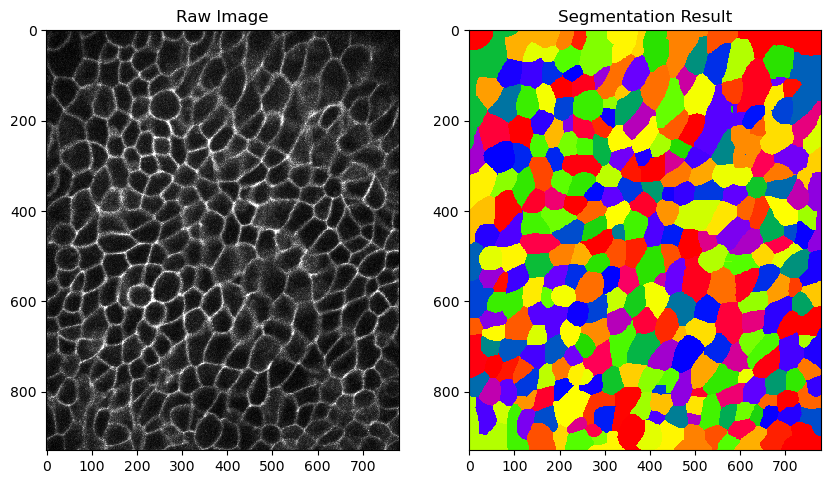

In [5]:
# (v) Look at the images to confirm that everything worked as intended

### YOUR CODE HERE!
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(seg, interpolation='none', cmap='prism')
ax[0].set_title('Raw Image')
ax[1].set_title('Segmentation Result')
plt.show()

## Postprocessing: Removing Cells at the Image Border <a id=postpro></a>

#### Background

Since segmentation is never perfect, it often makes sense to explicitely remove artifacts afterwards. For example, one could filter out objects that are too small, have a very strange shape, or very strange intensity values. 

**Warning:** Filtering out objects is equivalent to the *removal of outliers* in data analysis and *should only be done for good reason and with caution!*

As an example of postprocessing, we will now filter out a particular group of problematic cells: those that are being cut off at the image border.

#### <font color='teal'> Exercise </font>

Iterate through all the cells in your segmentation and remove those touching the image border.

Follow the instructions in the comments below. Note that the instructions will get a little less specific from here on, so you need to figure out how to approach a problem yourself.

In [6]:
# (i) Create an image border mask

# We need some way to check if a cell is at the border. For this, we generate a 'mask' of the image border,
# i.e. a Boolean array of the same size as the image where only the border pixels are set to `1` and all 
# others to `0`, like this:
#   1 1 1 1 1
#   1 0 0 0 1
#   1 0 0 0 1
#   1 0 0 0 1
#   1 1 1 1 1
# There are multiple ways of generating this mask, for example by erosion or by array indexing.
# It is up to you to find a way to do it. (Hint: one of the the easiest ways to do this is via scipy.ndimage.binary_dilation.
# check the parameter "border_value")

### YOUR CODE HERE!
border_mask = np.zeros(seg.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

In [7]:
# (ii) 'Delete' the cells at the border

# When modifying a segmentation (in this case by deleting some cells), it makes sense
# to work on a copy of the array, not on the original. This avoids unexpected behaviors,
# especially within jupyter notebooks. Use the function 'np.copy' to copy an array.
### YOUR CODE HERE!
clean_seg = np.copy(seg)

# Iterate over the IDs of all the cells in the segmentation. Use a for-loop and the 
# function 'np.unique' (remember that each cell in our segmentation is labeled with a 
# different integer value).
### YOUR CODE HERE!
for cell_ID in np.unique(seg):

    # Create a mask that contains only the 'current' cell of the iteration
    # Hint: Remember that the comparison of an array with some number (array==number)
    #       returns a Boolean mask of the pixels in 'array' whose value is 'number'.
    ### YOUR CODE HERE!
    cell_mask = seg==cell_ID
    
    # Using the cell mask and the border mask from above, test if the cell has pixels touching 
    # the image border or not.
    # Hint: 'np.logical_and'
    ### YOUR CODE HERE!
    cell_border_overlap = np.logical_and(cell_mask, border_mask)  # Overlap of cell mask and boundary mask
    total_overlap_pixels = np.sum(cell_border_overlap)            # Sum overlapping pixels
    
    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    ### YOUR CODE HERE!
    if total_overlap_pixels > 0: 
        clean_seg[cell_mask] = 0

In [8]:
# OPTIONAL: re-label the remaining cells to keep the numbering consistent from 1 to N (with 0 as background).
# Hint: Use python function <enumerate>

### YOUR CODE HERE!
for new_ID, cell_ID in enumerate(np.unique(clean_seg)[1:]):  # The [1:] excludes 0 from the list (background)!
    clean_seg[clean_seg==cell_ID] = new_ID+1                  # The same here for the +1

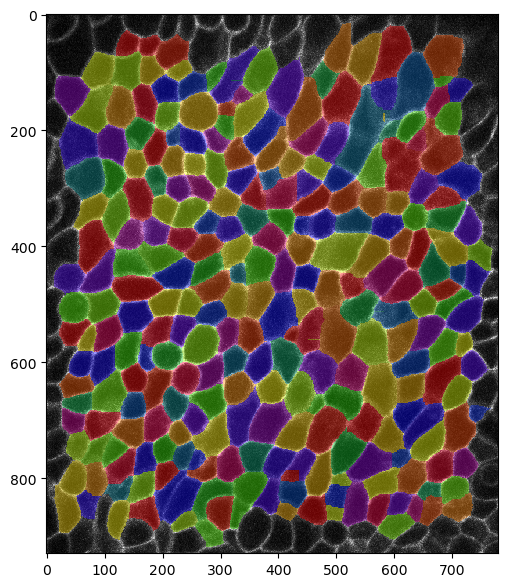

In [9]:
# (iii) Visualize the result

# Show the result as transparent overlay over the raw or smoothed image. 
# Here you have to combine alpha (to make cells transparent) and 'np.ma.array'
# (to hide empty space where the border cells were deleted).

### YOUR CODE HERE!
plt.figure(figsize=(7,7))
plt.imshow(img, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(clean_seg, mask=clean_seg==0), interpolation='none', cmap='prism', alpha=0.4)
plt.show()

## Identifying Cell Edges <a id=edges></a>

#### Background

With the final segmentation in hand, we can now start to think about measurements and data analysis. However, to extract interesting measurements from our cells, the segmentation on its own is often not enough: additional masks that identify sub-regions for each cell allow more precise and more biologically relevant measurements.

The most useful example of this is an additional mask that identifies only the edge pixels of each cell. This is useful for a number of purposes, including:

- Edge intensity is a good measure of membrane intensity, which is often a desired readout.
- The intensity profile along the edge may contain information on cell polarity.
- The length of the edge (relative to the cell area) is an informative feature about the cell shape. 
- Showing colored edges is a nice way of visualizing cell segmentations.

There are many ways of identifying edge pixels in a fully labeled segmentation. Here, we will use a simple and relatively fast method based on erosion.

#### <font color='teal'> Exercise </font>

Create a labeled mask of cell edges by following these steps:


- Create an array of the same size and data type as the segmentation but filled with only zeros
    - This will be your final cell edge mask; you gradually add cell edges as you iterate over cells
    

- *For each cell...*
    - Erode the cell's mask by 1 pixel
    - Using the eroded mask and the original mask, create a new mask of only the cell's edge pixels
    - Add the cell's edge pixels into the empty image generated above, labeling them with the cell's original ID number


Follow the instructions in the comments below.

In [10]:
# (i) Create an array of the same size and data type as the segmentation but filled with only zeros

### YOUR CODE HERE!
edges = np.zeros_like(clean_seg)

In [11]:
# (ii) Iterate over the cell IDs
### YOUR CODE HERE!
for cell_ID in np.unique(clean_seg)[1:]:
    
    # (iii) Erode the cell's mask by 1 pixel
    # Hint: 'ndi.binary_erode'
    ### YOUR CODE HERE!
    cell_mask = clean_seg == cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1) # Increase iterations to make boundary wider!
    # (iv) Create the cell edge mask
    # Hint: 'np.logical_xor'
    ### YOUR CODE HERE!
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    
    # (v) Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    ### YOUR CODE HERE!
    edges[edge_mask] = cell_ID

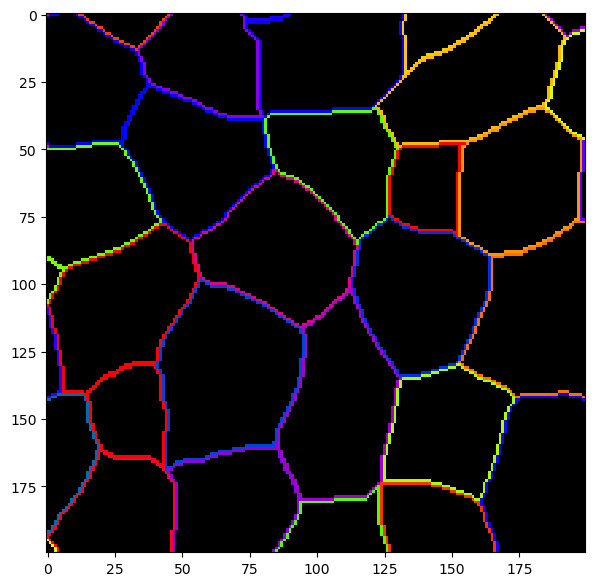

In [12]:
# (vi) Visualize the result

# Note: Because the lines are so thin (1pxl wide), they may not be displayed correctly in small figures.
#       You can 'zoom in' by showing a sub-region of the image which is then rendered bigger. You can
#       also go back to the edge identification code and make the edges multiple pixels wide (but keep 
#       in mind that this will have an effect on your quantification results!).

### YOUR CODE HERE!
plt.figure(figsize=(7,7))
plt.imshow(np.zeros_like(edges)[300:500, 300:500], cmap='gray', vmin=0, vmax=1)  # Simple black background
plt.imshow(np.ma.array(edges, mask=edges==0)[300:500, 300:500], interpolation='none', cmap='prism')
plt.show()

## Extracting Quantitative Measurements <a id=measure></a>

#### Background

The ultimate goal of image segmentation is of course the extraction of quantitative measurements, in this case on a single-cell level. Measures of interest can be based on intensity (in different channels) or on the size and shape of the cells.

To exemplify how different properties of cells can be measured, we will extract the following:

- Cell ID (so all other measurements can be traced back to the cell that was measured)
- Mean intensity of each cell
- Mean intensity at the membrane of each cell
- The cell area, i.e. the number of pixels that make up the cell
- The cell outline length, i.e. the number of pixels that make up the cell edge

*Note: It makes sense to use smoothed/filtered/background-subtracted images for segmentation. When it comes to measurements, however, it's best to get back to the raw data!*

#### <font color='teal'>Exercise</font>

Extract the measurements listed above for each cell and collect them in a dictionary.

Note: The ideal data structure for data like this is the `DataFrame` offered by the module `Pandas`. However, for the sake of simplicity, we will here stick with a dictionary of lists.

Follow the instructions in the comments below.

In [13]:
# (i) Create a dictionary that contains a key-value pairing for each measurement

# The keys should be strings describing the type of measurement (e.g. 'intensity_mean') and 
# the values should be empty lists. These empty lists will be filled with the results of the
# measurements.

### YOUR CODE HERE!
results = {"cell_id"      : [],
           "int_mean"     : [],
           "int_mem_mean" : [],
           "cell_area"    : [],
           "cell_edge"    : []}

# Solution note: the spacing between the strings and colons doesn't matter for the code's
# execution. It is used solely to make the code more readable!

In [14]:
# (ii) Record the measurements for each cell

# Iterate over the segmented cells ('np.unique').
# Inside the loop, create a mask for the current cell and use it to extract the measurements listed above. 
# Add them to the appropriate list in the dictionary using the 'append' method.
# Hint: Remember that you can get out all the values within a masked area by indexing the image 
#       with the mask. For example, 'np.mean(image[cell_mask])' will return the mean of all the 
#       intensity values of 'image' that are masked by 'cell_mask'!

### YOUR CODE HERE!
# Iterate over cell IDs
for cell_id in np.unique(clean_seg)[1:]:

    # Mask the current cell and cell edge
    cell_mask = clean_seg==cell_id
    edge_mask = edges==cell_id
    
    # Get the measurements
    results["cell_id"].append(cell_id)
    results["int_mean"].append(np.mean(img[cell_mask]))
    results["int_mem_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

In [15]:
# (iii) Print the results and check that they make sense

### YOUR CODE HERE!
for key in results.keys(): 
    print(key + ":", results[key][:5], '\n')

cell_id: [1, 2, 3, 4, 5] 

int_mean: [45.65185185185185, 55.141110065851365, 45.19132473622509, 43.14208333333333, 35.132607619990104] 

int_mem_mean: [89.85714285714286, 117.09821428571429, 92.08984375, 104.47928994082841, 71.71428571428571] 

cell_area: [1350, 1063, 4265, 2400, 4042] 

cell_edge: [126, 112, 256, 169, 224] 



## Simple Analysis & Visualisation <a id=analysis></a>

#### Background

By extracting quantitative measurements from an image we cross over from 'image analysis' to 'data analysis'. 

This section briefly explains how to do basic data analysis and plotting, including boxplots, scatterplots and linear fits. It also showcases how to map data back onto the image, creating an "image-based heatmap".

#### <font color='teal'>Exercise</font>

Analyze and plot the extracted data in a variety of ways.

Follow the instructions in the comments below.

In [16]:
# (i) Familiarize yourself with the data structure of the results dict and summarize the results

# Recall that dictionaries are unordered; a dataset of interest is accessed through its key.
# In our case, the datasets inside the dict are lists of values, ordered in the same order
# as the cell IDs. 

# For each dataset in the results dict, print its name (the key) along with its mean, standard 
# deviation, maximum, minimum, and median. The appropriate numpy methods (e.g. 'np.median') work
# with lists just as well as with arrays.

### YOUR CODE HERE!
# Custom function for nice printing of summary statistics.
# Note the use of format strings for nice number padding.
def print_summary(data):
    print( "  Mean:    {:7.2f}".format(np.mean(data))   )
    print( "  Stdev:   {:7.2f}".format(np.std(data))    )
    print( "  Max:     {:7.2f}".format(np.max(data))    )
    print( "  Min:     {:7.2f}".format(np.min(data))    )
    print( "  Median:  {:7.2f}".format(np.median(data)) )

# Calling the custom function for each dataset
for key in results.keys():
    print( '\n'+key )
    print_summary(results[key])
    
# There are also pre-made functions to get summary statistics,
# for example 'scipy.stats.describe'.
from scipy.stats import describe
stat_summary = describe(results['int_mean'])

print( '\nscipy.stats.describe of int_mean' )
for key in stat_summary._asdict().keys():
    print( ' ', key+': ', stat_summary._asdict()[key] )


cell_id
  Mean:     136.00
  Stdev:     78.23
  Max:      271.00
  Min:        1.00
  Median:   136.00

int_mean
  Mean:      57.22
  Stdev:     11.13
  Max:      107.12
  Min:       32.09
  Median:    56.28

int_mem_mean
  Mean:     120.07
  Stdev:     24.69
  Max:      185.31
  Min:       40.00
  Median:   120.33

cell_area
  Mean:    2129.03
  Stdev:    972.51
  Max:     6900.00
  Min:        3.00
  Median:  2091.00

cell_edge
  Mean:     162.82
  Stdev:     45.97
  Max:      400.00
  Min:        3.00
  Median:   161.00

scipy.stats.describe of int_mean
  nobs:  271
  minmax:  (32.08815520762423, 107.11764705882354)
  mean:  57.22026871783732
  variance:  124.44708713571605
  skewness:  0.8123981844192152
  kurtosis:  1.5531414154414644


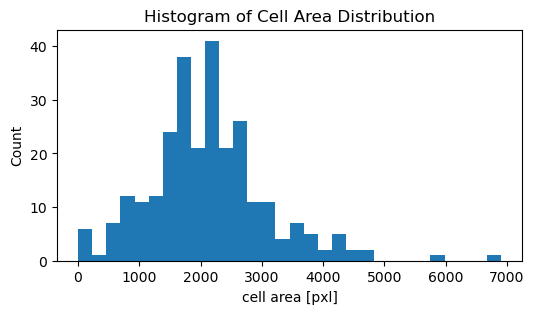

In [17]:
# (ii)-1 Create a histogram showing the distribution of cell surface area in pixels 

# Use the function 'plt.hist'. Change the "bins" parameter of the function to see the more detailed 
# trend of the data. What do you observe?

### YOUR CODE HERE!

plt.figure(figsize=(6,3))
num_bins = 30
plt.hist(results['cell_area'], bins = num_bins)
plt.xlabel('cell area [pxl]')
plt.ylabel('Count')
plt.title('Histogram of Cell Area Distribution')
plt.show()

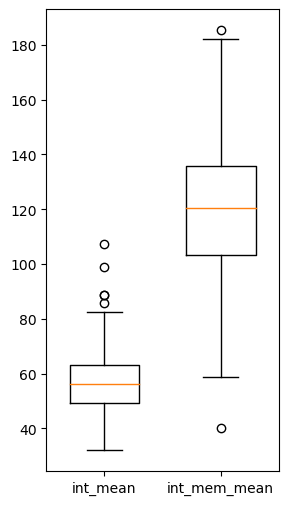

In [18]:
# (ii)-2 Create a box plot showing the mean cell and mean membrane intensities for both channels. 

# Use the function 'plt.boxplot'. Use the 'label' keyword of 'plt.boxplot' to label the x axis with 
# the corresponding key names. Feel free to play around with the various options of the boxplot 
# function to make your plot look nicer. Remember that you can first call 'plt.figure' to adjust 
# settings such as the size of the plot.

### YOUR CODE HERE!

plt.figure(figsize=(3,6))
plt.boxplot([results['int_mean'], results['int_mem_mean']], 
            labels=['int_mean', 'int_mem_mean'],
           widths=0.6)
plt.show()

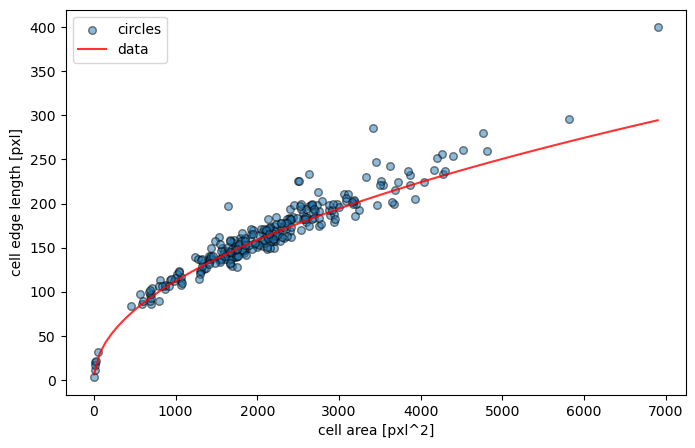

In [19]:
# (iii) Create a scatter plot of cell outline length over cell area

# Use the function 'plt.scatter' for this. Be sure to properly label the 
# plot using 'plt.xlabel' and 'plt.ylabel'.
# Note: it is a good idea to make the marker (the data point) more transparent so that
# where you found the plot less transparent it means there are data points overlapping.
### YOUR CODE HERE!

plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["cell_edge"],
           edgecolor='k', s=30, alpha=0.5)
plt.xlabel('cell area [pxl^2]')
plt.ylabel('cell edge length [pxl]')

# BONUS: Do you understand why you are seeing the pattern this produces? 
###
# ->> The curve reflects how circumference scales with area!

# Can you generate a 'null model' curve that assumes all cells to be circular?
### YOUR CODE HERE!
cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num = 100)
circle_circumference = 2*np.pi*np.sqrt(cell_area_range/ np.pi)
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['circles', 'data'], loc=2, fontsize=10)
plt.show()

# What is the result? Do you notice something odd about it? What could be the reason for
# this and how could it be fixed?
###
# ->> In general, the cells don't deviate all that much from the circular case.
# ->> Strangely, some cells have a smaller outline than the circumference of a circle
#     of equivalent area. This is mathematically impossible.
# ->> A possible reason could be that the measures are taken in pixels, which leads
#     to a so-called discretization error. It could be fixed by "meshing" the cell
#     outline and interpolating a more accurate measurement of circumference.

In [20]:
# (iv) Perform a linear fit of membrane intensity over cell area

# Use the function 'linregress' from the module 'scipy.stats'. Be sure to read the docs to
# understand the output of this function. Print the output.

### YOUR CODE HERE!

# Compute linear fit
from scipy.stats import linregress
linfit = linregress(results["cell_area"], results["int_mem_mean"])

# Print all the results
linprops = ['slope', 'intercept','rvalue','pvalue', 'stderr'] #linfit properties
for index,prop in enumerate(linprops):
    print( prop, '\t', '{:4.2e}'.format(linfit[index]) )

slope 	 4.39e-03
intercept 	 1.11e+02
rvalue 	 1.73e-01
pvalue 	 4.29e-03
stderr 	 1.52e-03


In [21]:
# (v) Think about the result

# Note that the fit seems to return a highly significant p-value but a very low correlation 
# coefficient (r-value). Based on prior knowledge, we would not expect a linear correlation of 
# this sort to be present in our data. 
#
# This should prompt several questions:
#   1) What does this p-value actually mean? Check the docs of 'linregress'!
###
#       ->> This p-value only means that, given a linear fit through this data, the slope of the
#           fit is very unlikely to be zero. However, it does not make a statement on whether or
#           not it makes sense to use a linear fit in the first place. Looking at the scatterplot
#           below or at the correlation coefficient r, it is clear that a linear fit on this data
#           is not meaningful.
#       ->> Note also: With single-cell approaches, we quickly get to a large number of data points. 
#           This makes hypothesis testing in general less useful, as p-values tend to become very
#           small even if the null hypothesis holds. It makes sense to instead report effect sizes.
#           This is a tricky topic but well worth reading up on.
#
#   2) Could there be artifacts in our segmentation that bias this analysis?
###
#       ->> Oversegmentation is an important source of bias here. If a cell is oversegmented,
#           it will be considered as two or three cells. These will naturally have a lower
#           cell area and will naturally have a lower membrane intensity because some of their
#           edges are actually not on membranes. In other words, they will fall into the bottom
#           left of the plot, distorting the data.
#
# In general, it's always good to be very careful when doing any kind of data analysis. Make sure you 
# understand the functions you are using and always check for possible errors or sources of bias!

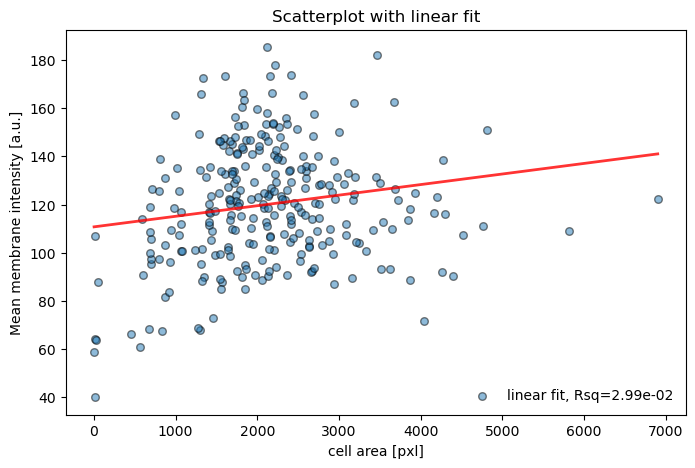

In [22]:
# (vi) Overlay the linear fit onto a scatter plot

# Recall that a linear function is defined by `y = slope * x + intercept`.

# To define the line you'd like to plot, you need two values of x (the starting point and
# and the end point of the line). What values of x make sense? Can you get them automatically?
### YOUR CODE HERE!
#   ->> The max and min values in the data are a good choice.
x_vals = [min(results["cell_area"]), max(results["cell_area"])]

# When you have the x-values for the starting point and end point, get the corresponding y 
# values from the fit through the equation above.
### YOUR CODE HERE!
y_vals = [linfit[0] * x_vals[0] + linfit[1], linfit[0] * x_vals[1] + linfit[1]]

# Plot the line with 'plt.plot'. Adjust the line's properties so it is well visible.
# Note: Remember that you have to create the scatterplot before plotting the line so that
#       the line will be placed on top of the scatterplot.
### YOUR CODE HERE!
plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["int_mem_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)

# Use 'plt.legend' to add information about the line to the plot.
### YOUR CODE HERE!
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)

# Label the plot and finally show it with 'plt.show'.
### YOUR CODE HERE!
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")
plt.show()

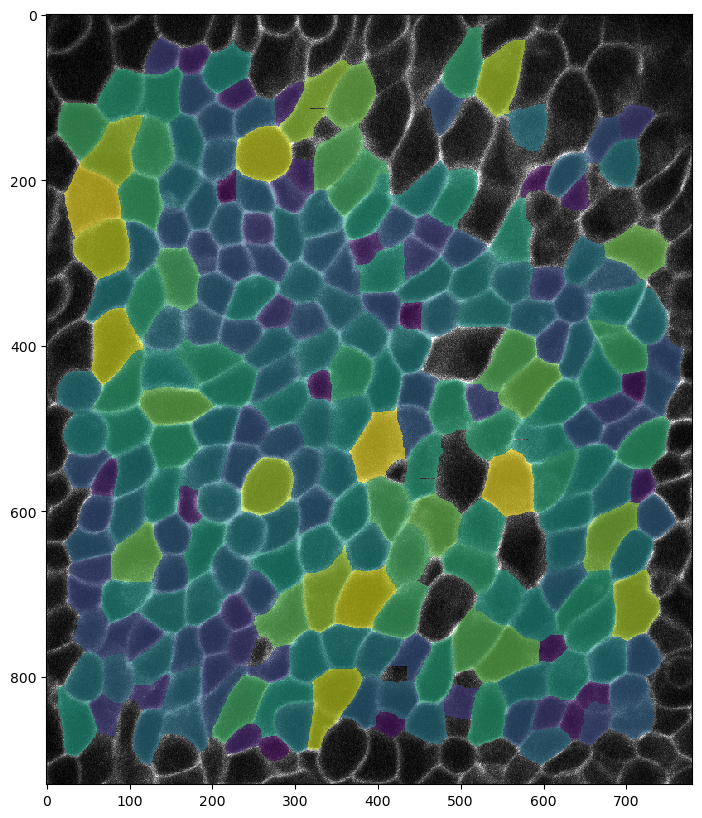

In [23]:
# (vii) Map the cell area back onto the image as a 'heatmap'

# Scale the cell area data to 8bit so that it can be used as pixel intensity values.
# Hint: if the largest cell area should correspond to the value 255 in uint8, then 
#       the other cell areas correspond to 'cell_area * 255 / largest_cell_area'.
# Hint: To perform an operation on all cell area values at once, convert the list 
#       of cell areas to a numpy array.
### YOUR CODE HERE!
areas_8bit = np.array(results["cell_area"]) / max(results["cell_area"]) * 255

# Initialize a new image array; all values should be zeros, the shape should be identical 
# to the images we worked with before and the dtype should be uint8.
### YOUR CODE HERE!
area_map = np.zeros_like(clean_seg, dtype = np.uint8)

# Iterate over the segmented cells. In addition to the cell IDs, the for-loop should
# also include a simple counter (starting from 0) with which the area measurement can be 
# accessed by indexing.
### YOUR CODE HERE!
for index, cell_id in enumerate(results["cell_id"]):

    # Mask the current cell and assign the cell's (re-scaled) area value to the cell's pixels.
    ### YOUR CODE HERE!
    area_map[clean_seg==cell_id] = areas_8bit[index]
    
# Visualize the result as a colored semi-transparent overlay over the raw/smoothed original input image.
# BONUS: See if you can exclude outliers to make the color mapping more informative!
### YOUR CODE HERE!

# Mask of outliers (the largest and smallest 5% of all cells)
outlier_mask = np.logical_or(area_map > np.percentile(areas_8bit, 95),
                             area_map < np.percentile(areas_8bit, 5))

# Mask of all regions to leave blank (outliers + image boundary cells)
full_mask = np.logical_or(area_map==0, outlier_mask)

# Create the plot
plt.figure(figsize=(10,10))
plt.imshow(img, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(area_map, mask=full_mask),
           interpolation='none', cmap='viridis', alpha=0.6)
plt.show()

## Writing Output to Files <a id=write></a>

#### Background

The final step of the pipeline shows how to write various outputs of the pipeline to files.

Data can be saved to files in a human-readable format such as text files (e.g. to import into Excel), in a format readable for other programs such as tif-images (e.g. to view in Fiji) or in a language-specific file that makes it easy to reload the data into python in the future (e.g. for further analysis).

#### <font color='teal'> Exercise </font>

Write the generated data into a variety of different output files.

Follow the instructions in the comments below.

In [24]:
# (i) Write one or more of the images you produced to a tif file

# Use the function 'imsave' from the 'skimage.io' module. Make sure that the array you are 
# writing is of integer type. If necessary, you can use the method 'astype' for conversions, 
# e.g. 'some_array.astype(np.uint8)' or 'some_array.astype(np.uint16)'. Careful when 
# converting a segmentation to uint8; if there are more than 255 cells, the 8bit format
# doesn't have sufficient bit-depth to represent all cell IDs!
#
# You can also try adding the segmentation to the original image, creating an image with
# two channels, one of them being the segmentation. 
#
# After writing the file, load it into Fiji and check that everything worked as intended.

### YOUR CODE HERE!
from skimage.io import imsave
imsave("example_cells_1_edges.tif", edges.astype(np.uint16))

C:\Users\OWNER\AppData\Local\Temp\ipykernel_21340\964530861.py:16: UserWarning: example_cells_1_edges.tif is a low contrast image
  imsave("example_cells_1_edges.tif", edges.astype(np.uint16))


In [25]:
# (ii) Write a figure to a png or pdf

# Recreate the scatter plot from above (with or without the regression line), then save the figure
# as a png using 'plt.savefig'. Alternatively, you can also save it to a pdf, which will create a
# vector graphic that can be imported into programs like Adobe Illustrator.

### YOUR CODE HERE!
# Create plot (but don't show)
plt.scatter(results["cell_area"], results["int_mem_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")

# Save as png and pdf
plt.savefig('example_cells_1_scatterFit.png')
plt.savefig('example_cells_1_scatterFit.pdf')
plt.clf()  # Clear the figure buffer

<Figure size 640x480 with 0 Axes>

In [26]:
# (iii) Save the segmentation as a numpy file

# Numpy files allow fast storage and reloading of numpy arrays. Use the function 'np.save'
# to save the array and reload it using 'np.load'.

### YOUR CODE HERE!
np.save("example_cells_1_seg", clean_seg)  # Save
seg = np.load("example_cells_1_seg.npy")  # Load
print(clean_seg.shape, seg.shape)

(930, 780) (930, 780)


In [27]:
# (iv) Save the result dictionary as a pickle file

# Pickling is a way of generating generic files from almost any python object, which can easily
# be reloaded into python at a later point in time.
# You will need to open an empty file object using 'open' in write-bytes mode ('wb'). It's best to  
# do so using the 'with'-statement (context manager) to make sure that the file object will be 
# closed automatically when you are done with it.
# Use the function 'pickle.dump' from the 'pickle' module to write the results to the file.
# Hint: Refer to the python documention for input and output to understand how file objects are
#       handled in python in general.

### YOUR CODE HERE!
import pickle
with open('example_cells_1_results.pkl','wb') as outfile:
    pickle.dump(results, outfile)

## Note: Pickled files can be re-loaded again as follows:
#with open('my_filename.pkl', 'rb') as infile:
#    reloaded = pickle.load(infile)
with open('example_cells_1_results.pkl', 'rb') as infile:
    results_reloaded = pickle.load(infile)
    print(results_reloaded.keys())

dict_keys(['cell_id', 'int_mean', 'int_mem_mean', 'cell_area', 'cell_edge'])


In [28]:
# (v) Write a tab-separated text file of the results dict

# The most generic way of saving numeric results is a simple text file. It can be imported into 
# pretty much any other program.

# To write normal text files, open an empty file object in write mode ('w') using the 'with'-statement.
### YOUR CODE HERE!
with open('example_cells_1_results.txt','w') as outfile:
    # Use the 'file_object.write(string)' method to write strings to the file, one line at a time,
    # First, write the header of the data (the result dict keys), separated by tabs ('\t'). 
    # It makes sense to first generate a complete string with all the headers and then write this 
    # string to the file as one line. Note that you will need to explicitly write 'newline' characters 
    # ('\n') at the end of the line to switch to the next line.
    # Hint: the string method 'join' is very useful here!
    ### YOUR CODE HERE!
    header_string = '\t'.join(results.keys()) + '\n'
    outfile.write(header_string)
    
    # After writing the headers, iterate over all the cells and write the result data to the file line
    # by line, by creating strings similar to the header string.
    ### YOUR CODE HERE!
    for index in range(len(results['cell_id'])):
        data_string = '\t'.join([str(results[key][index]) for key in results.keys()]) + '\n'
        outfile.write(data_string)

# After writing the data, have a look at the output file in a text editor or in a spreadsheet
# program like Excel.

## \**BONUS\** >> Batch Processing <a id=batch></a>

#### Background

In practice, we never work with just a single image, so we would like to make it possible to run our analysis pipeline for multiple images and then collect and analyze all the results. This final section of the tutorial shows how to do just that.

#### <font color='teal'>Exercise</font>

To run a pipeline multiple times, it needs to be packaged into a function or - even better - as a separate module. Jupyter notebook is not well suited for this, so if you're working in a notebook, first extract your code to a `.py` file (see instructions below). If you are not working in a notebook, create a copy of your pipeline; we will modify this copy into a function that can then be called repeatedly for different images.

To export a jupyter notebook as a `.py` file, use `File > Download as > Python (.py)`, then save the file. Open the resulting python script in a text editor or in an IDE like PyCharm. 


#### Let's clean the script a bit:

- Remove the line `%matplotlib [inline|notebook|qt]`. It is not valid python code outside of a Jupyter notebook.


- Go through the script and comment out everything related to plotting; when running a pipeline for dozens or hundreds of images, we usually do not want to generate tons of plots. Similarly, it can make sense to remove some print statments if you have many of them.


- Remove the sections `Manual Thresholding` and `Connected Components Labeling`; they are not used in the final segmentation.


- Remove the sections `Simple Analysis and Visualization` and `Writing Output to Files`; we will collect the output for each image when running the pipeline in a loop. That way, everything can be analyzed at once at the end. 
    - Note that, even though we skip it here, it is often very useful to store every input file's corresponding outputs in new files. When doing so, the output files should use the name of the input file modified with an additional suffix. For example, the results extracted when analyzing `img_1.tif` might best be stored as `img_1_results.pkl`.
    - You can implement this approach for saving the segmentations and/or the result dicts as a *bonus* exercise!


- Feel free to delete some of the background information to make the script more concise.


#### Converting the pipeline to a function:

Convert the entire pipeline into a function that accepts a directory and a filename as input, runs everything, and returns the final segmentation and the results dictionary. To do this, you must:

- Add the function definition statement at the beginning of the script (after the imports)
- Replace the 'hard-coded' directory path and filename by variables that are accepted by the function
- Indent all the code
- Add a return statement at the end


#### Importing the function and running it for multiple input files:

To actually run the pipeline function for multiple input files, we need to do the following:

- Import the pipeline function from the `.py` file
- Iterate over all the filenames in a directory
- For each filename, call the pipeline function
- Collect the returned results

Once you have converted your pipeline into a function as described above, you can import and run it according to the instructions below.

In [29]:
###

#### Solution Note

The converted version of the pipeline can be found in `batch_processing_solution.py`. 

Note that the most of the exercise comments have been removed so it doesn't look too cluttered. However, this level of clean-up is probably a bit extreme; it is generally recommended to retain at least basic comments on the purpose of each code block. 

Also note that a doc string was added to the function definition (the string designated with three `"""` at the start and end, directly under the function definition). This is a very useful reference, since it is automatically recognized as a help message by Jupyter notebook (and other IDEs), so you can easily double-check what an imported function does, for example by typing `run_pipeline?` in a code cell.

C:\Users\OWNER\Documents\#Bioimage_Analysis_workshop\Scripts\Ready_for_release\batch_processing_solution.py:65: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  bg = rank.mean(img_smooth, selem=SE)
C:\Users\OWNER\Documents\#Bioimage_Analysis_workshop\Scripts\Ready_for_release\batch_processing_solution.py:91: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  seeds = peak_local_max(dist_trans_smooth, indices=False, min_distance=10)


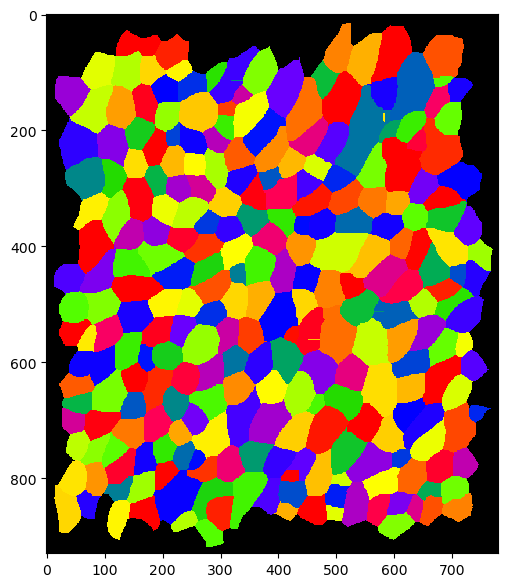

In [30]:
# (i) Test if your pipeline function actually works

# Import your function using the normal python syntax for imports, like this:
#   from your_module import your_function
# Run the function and visualize the resulting segmentation. Make sure everything works as intended.

### YOUR CODE HERE!
from batch_processing_solution import run_pipeline
pip_seg, pip_results = run_pipeline(r"example_data", r'example_cells_1.tif')

plt.figure(figsize=(7,7))
plt.imshow(np.zeros_like(pip_seg), interpolation='none', cmap='gray', vmax=1)  # Simple black background
plt.imshow(np.ma.array(pip_seg, mask=pip_seg==0), interpolation='none', cmap='prism')
plt.show()

In [31]:

# (ii) Get all relevant filenames from the input directory

# Use the function 'listdir' from the module 'os' to get a list of all the files
# in a directory. Find a way to filter out only the relevant input files, namely
# "example_cells_1.tif" and "example_cells_2.tif". Of course, one would usually
# do this for many more images, otherwise it's not worth the effort.
# Hint: Loop over the filenames and use if statements to decide which ones to 
#       keep and which ones to throw away.

### YOUR CODE HERE!
# Get all files
dirpath = r"example_data"
from os import listdir
filelist = listdir(dirpath)

# Filter for target files: simple option
# Note that this will use ALL files with a .tif ending, which in some circumstances
# may include files that are not supposed to be used!
target_files = []
for fname in filelist:
    if fname.endswith('.tif'):
        target_files.append(fname)
print(target_files)

# Filter for target files: advanced option using regex and a list comprehension
import re
target_pattern = re.compile("^example_cells_\d+\.tif$")
target_files = [fname for fname in filelist if target_pattern.match(fname)]
print(target_files)

['example_cells_1.tif', 'example_cells_2.tif', 'xy_8bit__nuclei_high_dynamic_range.tif']
['example_cells_1.tif', 'example_cells_2.tif']


In [32]:
# (iii) Iterate over the input filenames and run the pipeline function

# Be sure to collect the output of the pipeline function in a way that allows
# you to trace it back to the file it came from. You could for example use a
# dictionary with the filenames as keys.

### YOUR CODE HERE!
# Initialize empty dictionaries
all_seg = {}
all_results = {}

# Iterate over files and run pipeline for each
for fname in target_files:
    pip_seg, pip_results = run_pipeline(dirpath, fname)
    all_seg[fname] = pip_seg
    all_results[fname] = pip_results

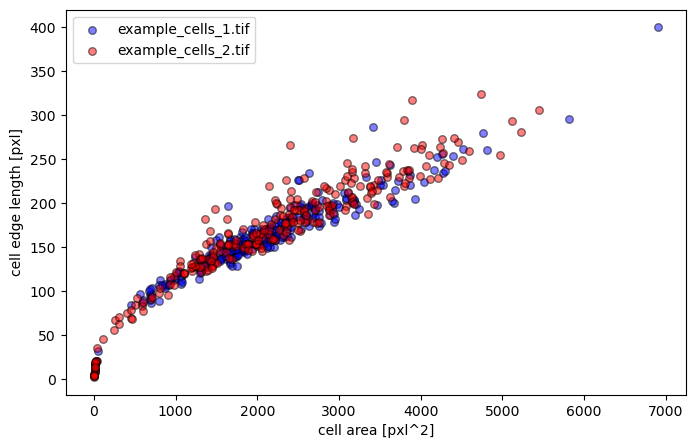

In [33]:
# (iv) Recreate one of the scatterplots from above but this time with all the cells

# You can color-code the dots to indicate which file they came from. Don't forget to
# add a corresponding legend.

### YOUR CODE HERE!
plt.figure(figsize=(8,5))

colors = ['blue','red']
for key, color in zip(sorted(all_results.keys()), colors):
    plt.scatter(all_results[key]["cell_area"], all_results[key]["cell_edge"],
                edgecolor='k', c=color, s=30, alpha=0.5, label=key)
    
plt.legend()
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")
plt.show()

## <font color='teal'>*Congratulations! You have completed the tutorial!*</font>

**We hope you enjoyed the ride and learned a lot!**

### Concluding Remarks

It's important to remember that the phrase ***"Use it or loose it!"*** fully applies for the skills taught in this tutorial.

If you now just go back to the lab and don't touch python or image analysis for the next half year, most of the things you have learned here will be lost.

So, what can you do?


- If possible, start applying what you have learned to your own work right away


- Even if your current work doesn't absolutely *need* coding / image analysis (which to be honest is hard to believe! ;p), you can still use it at least to make some nice plots!


- Another very good approach is to find yourself an interesting little side project you can play around with

***We wish you the best of luck for all your coding endeavors!***